# Random forests intro and regression

Random Forests are powerful machine learning algorithms used for supervised classification and regression. Random forests works by averaging the predictions of the multiple and randomized decision trees. Decision trees tends to overfit and so by combining multiple decision trees, the effect of overfitting can be minimized. 

Random Forests are type of ensemble models. More about ensembles models in the next notebook. 

Different to other learning algorithms, random forests provide a way to find the importance of each feature and this is implemented in Sklearn. 

## Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

## Loading the data

In this regression task with random forests, we will use the Machine CPU (Central Processing Unit) dataset which is available at [OpenML](https://www.openml.org/t/5492). We will load it with Sklearn `fetch_openml` function. 

If you are reading this, it's very likely that you know CPU or you have once(or many times) thought about it when you were buying your computer. In this notebook, we will predict the relative performance of the CPU given the following data: 

* MYCT: machine cycle time in nanoseconds (integer)
* MMIN: minimum main memory in kilobytes (integer)
* MMAX: maximum main memory in kilobytes (integer)
* CACH: cache memory in kilobytes (integer)
* CHMIN: minimum channels in units (integer)
* CHMAX: maximum channels in units (integer)
* PRP: published relative performance (integer) (target variable)

In [2]:
# Let's hide warnings

import warnings

warnings.filterwarnings("ignore")

In [3]:
from sklearn.datasets import fetch_openml

machine_cpu = fetch_openml(name="machine_cpu", version=1)

In [4]:
type(machine_cpu)

sklearn.utils._bunch.Bunch

In [5]:
machine_cpu.details

{'id': '230',
 'name': 'machine_cpu',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'contributor': 'L. Torgo',
 'upload_date': '2014-04-23T13:20:36',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://api.openml.org/data/v1/download/3667/machine_cpu.arff',
 'parquet_url': 'http://openml1.win.tue.nl/dataset230/dataset_230.pq',
 'file_id': '3667',
 'default_target_attribute': 'class',
 'version_label': '1',
 'citation': 'https://archive.ics.uci.edu/ml/citation_policy.html',
 'tag': 'OpenML-Reg19',
 'visibility': 'public',
 'original_data_url': 'http://www.ics.uci.edu/~mlearn/MLSummary.html',
 'minio_url': 'http://openml1.win.tue.nl/dataset230/dataset_230.pq',
 'status': 'active',
 'processing_date': '2020-11-20 19:15:43',
 'md5_checksum': 'e26d62e83069b74dff6cf492e06868a0'}

In [6]:
machine_cpu.data.shape

(209, 6)

In [7]:
print(machine_cpu.DESCR)

**Author**:   
**Source**: Unknown -   
**Please cite**:   

The problem concerns Relative CPU Performance Data. More information can be obtained in the UCI Machine
 Learning repository (http://www.ics.uci.edu/~mlearn/MLSummary.html).
 The used attributes are :
 MYCT: machine cycle time in nanoseconds (integer)
 MMIN: minimum main memory in kilobytes (integer)
 MMAX: maximum main memory in kilobytes (integer)
 CACH: cache memory in kilobytes (integer)
 CHMIN: minimum channels in units (integer)
 CHMAX: maximum channels in units (integer)
 PRP: published relative performance (integer) (target variable)
 
 Original source: UCI machine learning repository. 
 Source: collection of regression datasets by Luis Torgo (ltorgo@ncc.up.pt) at
 http://www.ncc.up.pt/~ltorgo/Regression/DataSets.html
 Characteristics: 209 cases; 6 continuous variables

Downloaded from openml.org.


In [8]:
# Getting the whole dataframe

machine_data = machine_cpu.frame

In [9]:
type(machine_data)

pandas.core.frame.DataFrame

In [10]:
machine_data.shape

(209, 7)

In [11]:
machine_data.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,class
0,125.0,256.0,6000.0,256.0,16.0,128.0,198.0
1,29.0,8000.0,32000.0,32.0,8.0,32.0,269.0
2,29.0,8000.0,32000.0,32.0,8.0,32.0,220.0
3,29.0,8000.0,32000.0,32.0,8.0,32.0,172.0
4,29.0,8000.0,16000.0,32.0,8.0,16.0,132.0


### Task 1: Exploratory analysis

Before doing exploratory analysis, let's get the training and test data. 

In [12]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(machine_data, test_size=0.2, random_state=20)
print(
    "The size of training data is: {} \nThe size of testing data is: {}".format(
        len(train_data), len(test_data)
    )
)

The size of training data is: 167 
The size of testing data is: 42


Let's visualize the histograms of all numeric features. 

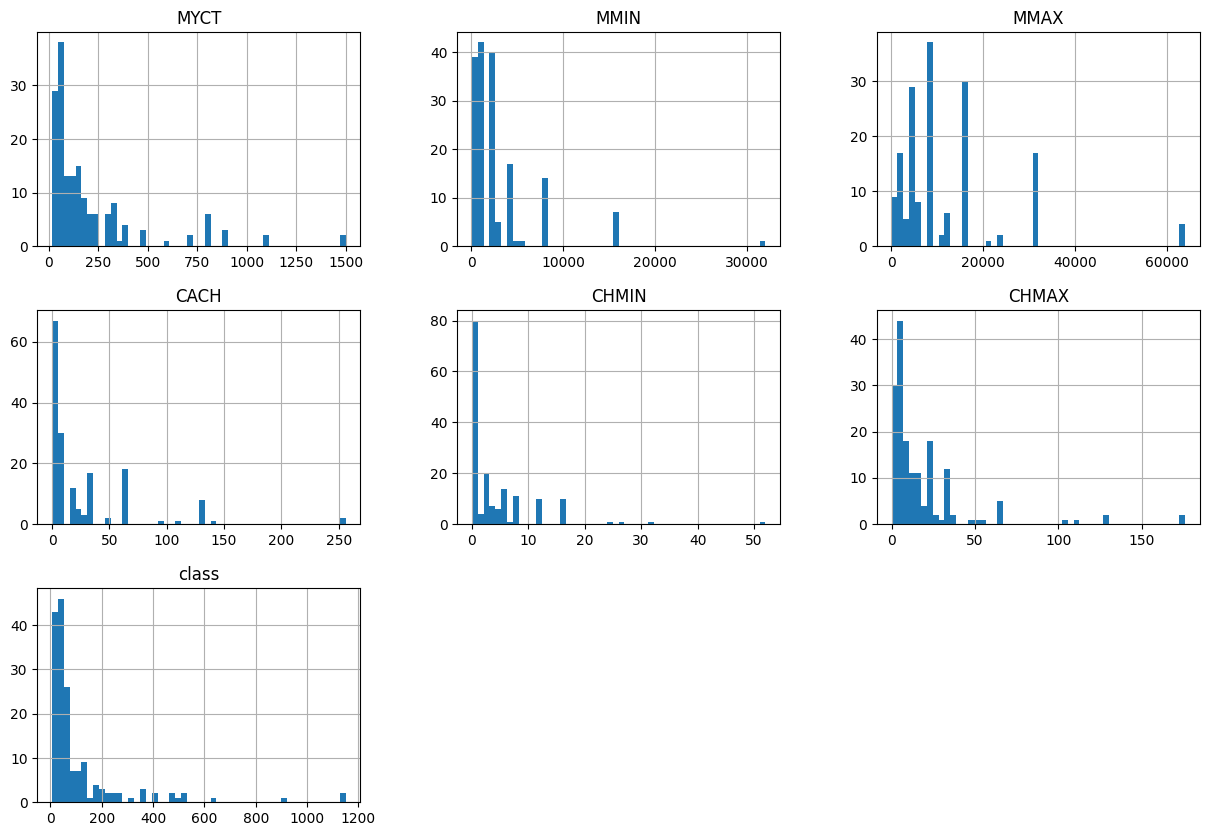

In [13]:
train_data.hist(bins=50, figsize=(15, 10))
plt.show()

Or we can quickly use `sns.pairplot()` to look into the data. 

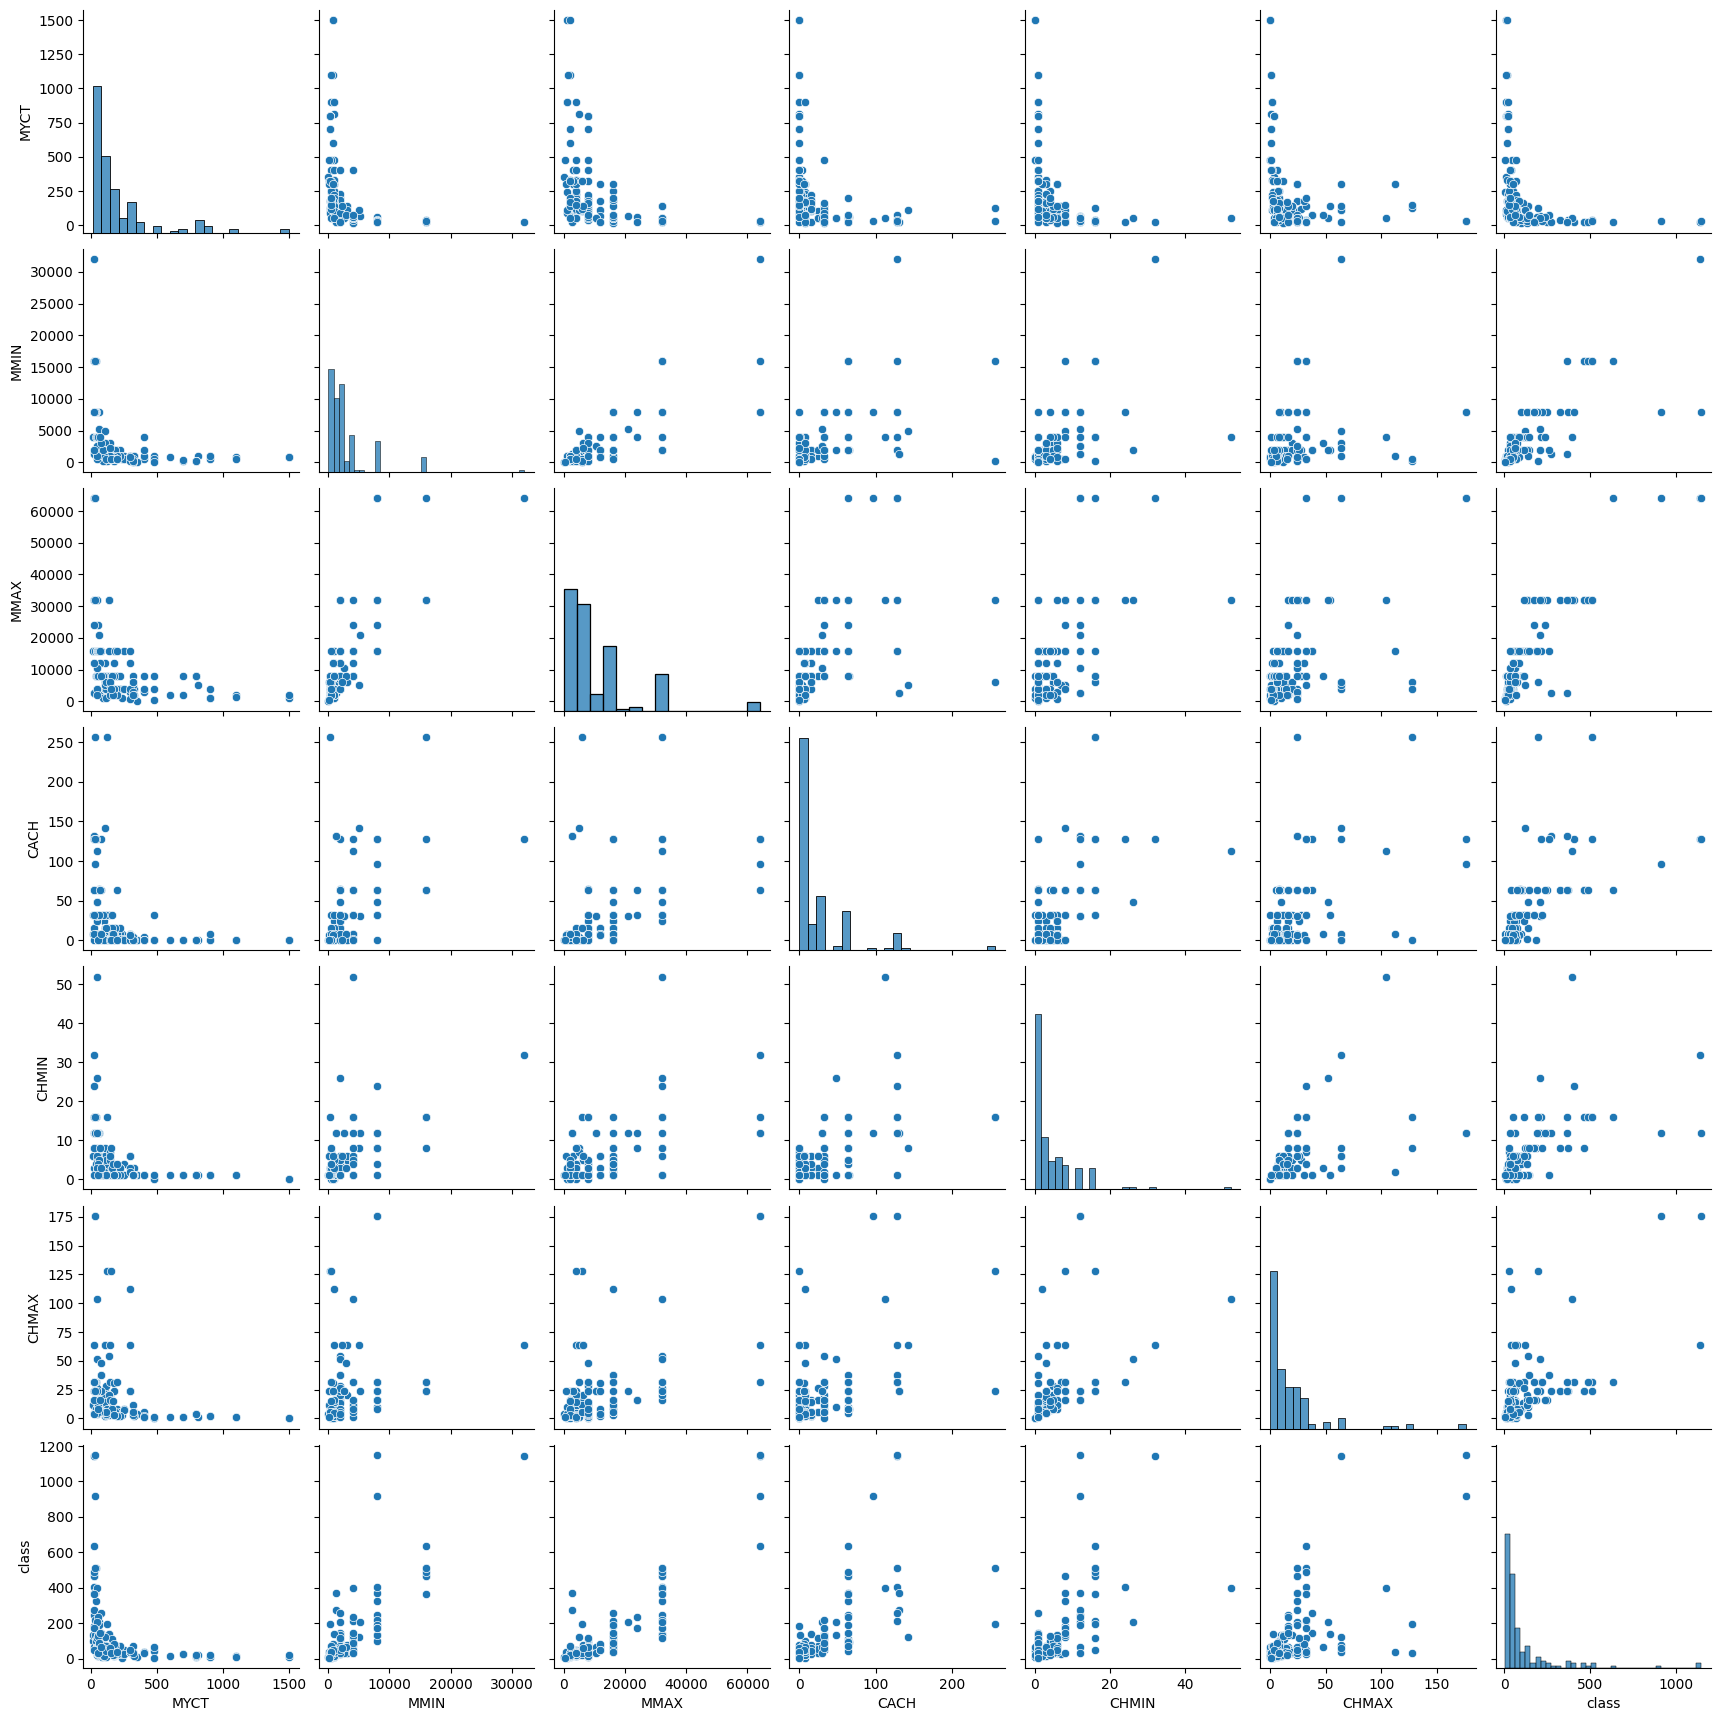

In [14]:
sns.pairplot(train_data)

In [15]:
# Checking summary stats
train_data.describe()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,class
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,207.958084,2900.826347,11761.161677,26.071856,4.760479,18.616766,109.185629
std,266.772823,4165.950964,12108.332354,42.410014,6.487439,27.489919,174.061117
min,17.000000,64.000000,64.000000,0.000000,0.000000,0.000000,6.000000
25%,50.000000,768.000000,4000.000000,0.000000,1.000000,5.000000,27.500000
50%,110.000000,2000.000000,8000.000000,8.000000,2.000000,8.000000,50.000000
75%,232.500000,3100.000000,16000.000000,32.000000,6.000000,24.000000,110.000000
max,1500.000000,32000.000000,64000.000000,256.000000,52.000000,176.000000,1150.000000


In [16]:
# Checking missing values

train_data.isnull().sum()

MYCT     0
MMIN     0
MMAX     0
CACH     0
CHMIN    0
CHMAX    0
class    0
dtype: int64

We don't have any missing values. 

In [17]:
# Checking feature correlation

corr = train_data.corr()
corr["class"]

MYCT    -0.301805
MMIN     0.797751
MMAX     0.869077
CACH     0.671581
CHMIN    0.648653
CHMAX    0.606557
class    1.000000
Name: class, dtype: float64

<AxesSubplot: >

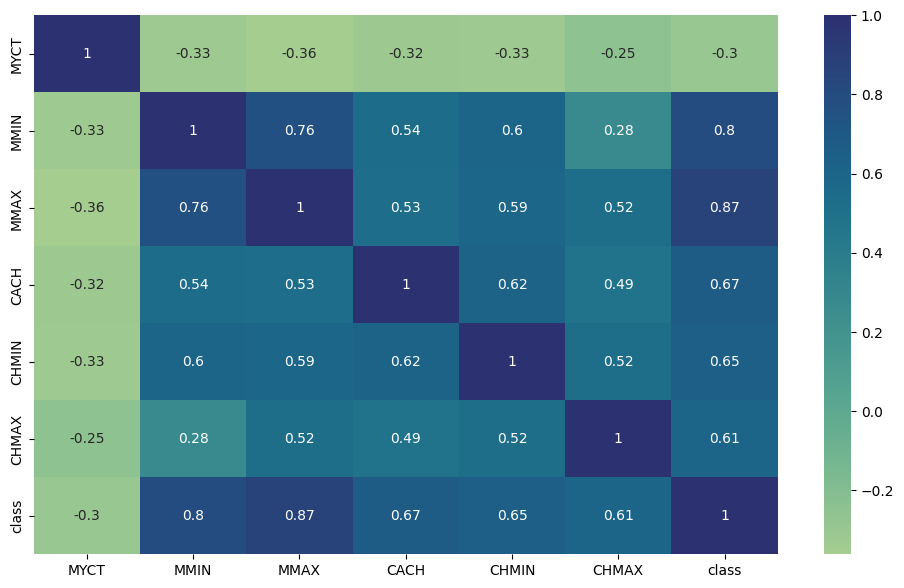

In [18]:
## Visualizing correlation

plt.figure(figsize=(12, 7))
sns.heatmap(corr, annot=True, cmap="crest")

### Task 2: Data preprocessing

It is here that we prepare the data to be in the proper format for the machine learning model. 
Let's set up a pipeline to scale features but before that, let's take training input data and labels.

In [19]:
X_train = train_data.drop("class", axis=1)
y_train = train_data["class"]

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

scale_pipe = Pipeline([("scaler", StandardScaler())])
X_train_scaled = scale_pipe.fit_transform(X_train)

### Task 3: Training random forests regressor

In [21]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(
    min_samples_split=2, bootstrap=False, random_state=42, n_jobs=-1
)

forest_reg.fit(X_train_scaled, y_train)

RandomForestRegressor(bootstrap=False, n_jobs=-1, random_state=42)



### Task 4: Evaluating random forests regressor

Let's first check the root mean squarred errr on the training. It is not advised to evaluate the model on the test data since we haven't improved it yet. we will make a function to make it easier and to avoid repetitions. 

In [22]:
from sklearn.metrics import mean_squared_error


def predict(input_data, model, labels):
    """
    Take the input data, model and labels and return predictions

    """

    preds = model.predict(input_data)
    mse = mean_squared_error(labels, preds)
    rmse = np.sqrt(mse)

    return rmse

In [23]:
predict(X_train_scaled, forest_reg, y_train)

9.724590719956222

### Task 5: Improving random forests

In [24]:
forest_reg.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

We will use GridSearch to find the best hyperparameters that we can use to retrain the model with. By setting the `refit` to `True`, the random forest will be automatically retrained on the dataset with the best hyperparameters. By default, `refit` is True.

This will take too long. 

In [25]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_leaf_nodes": list(range(2, 52)),
}

# refit is true by default. The best estimator is trained on the whole dataset

grid_search = GridSearchCV(
    RandomForestRegressor(min_samples_split=2, bootstrap=False, random_state=42),
    params_grid,
    verbose=1,
    cv=5,
)

grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


GridSearchCV(cv=5,
             estimator=RandomForestRegressor(bootstrap=False, random_state=42),
             param_grid={'max_leaf_nodes': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                            13, 14, 15, 16, 17, 18, 19, 20, 21,
                                            22, 23, 24, 25, 26, 27, 28, 29, 30,
                                            31, ...],
                         'n_estimators': [100, 200, 300, 400, 500]},
             verbose=1)

In [26]:
grid_search.best_params_

{'max_leaf_nodes': 46, 'n_estimators': 200}

In [27]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=False, max_leaf_nodes=46, n_estimators=200,
                      random_state=42)

In [28]:
forest_best = grid_search.best_estimator_

Let's make prediction on the training data again

In [29]:
predict(X_train_scaled, forest_best, y_train)

12.217411163164076

Surprisingly, by searching model hyperparameters, the model did not improve. Can you guess why? We can observe many things while running Grid Search and reading about the [random forests](https://scikit-learn.org/stable/modules/ensemble.html#forests-of-randomized-trees). If you can't get good results, set the `bootstrap` to False. It is true by default, and that means that you are training on samples of the training set instead of the whole training set. Try going back to the orginal model and change it to True and note how the prediction changes. Also learn more about the other hyperparameters. 

### Task 6: Feature importance 

Different to other machine learning models, random forests can show how each feature contributed to the model generalization. Let's find it.
The results are values between 0 and 1. The closer to 1, the good the feature was to the model.

In [30]:
feat_import = forest_best.feature_importances_

feat_dict = {"Features": X_train.columns, "Feature Importance": feat_import}

pd.DataFrame(feat_dict)

,Features,Feature Importance
0,MYCT,0.002990
1,MMIN,0.005777
2,MMAX,0.835472
3,CACH,0.117459
4,CHMIN,0.007567
5,CHMAX,0.030735


As you can see above, the most 2 features which contributed to the prediction of the relative performance of the CPU are `MMAX` which is the Maximum Main Memory in Kilobytes and `CACH` (cache memory). 

It makes sense that the model was able to find that out. Main memory (RAM, Read Only Memory) and cache memory (which stores frequently used information thus facilitating faster processing and quick retrieval of information) are the two most factors of the CPU performance and if you are going to buy a new computer, you want to have high RAM and cache memory in order to have a powerful machine that can process/compute and retrieve things faster. 

### Task 7: Evaluating the Model on the Test Set

Let us evaluate the model on the test set. But we need first run the pipeline on the test data. Note that we only transform (not fit_transform).

In [31]:
X_test = test_data.drop("class", axis=1)
y_test = test_data["class"]

test_scaled = scale_pipe.transform(X_test)

In [32]:
predict(test_scaled, forest_best, y_test)

41.258341325352305

The results on the test set is not appealing, and it is a sign that the model is still overfitting the data(it is doing well on the training set and poor on the new data). One way to improve the model can be to regularize the model by searching more best hyperparameters and increasing the data and data quality. The later is what can improve the model in many scenarios. 

This is the end of this assignment. We have learned the fundamental idea behind the random forests, and used it to predict the CPU performance. In the next assignment, we will use it for classification task and we will use a real world dataset so that we can practically improve the random forests.

## Acknowledgments

Thanks to Nyandwi for creating the open-source course [Machine Learning complete](https://github.com/Nyandwi/machine_learning_complete). It inspires the majority of the content in this chapter.